# Transfer Learning

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense,Flatten,Conv2D,Dropout,MaxPool2D
from tensorflow.keras.models import Sequential
import numpy as np
import os
from datetime import datetime

In [ ]:
%load_ext tensorboard

## Same Distribution

In [ ]:
mnist = keras.datasets.mnist
(x_train,y_train),(x_test,y_test) = mnist.load_data()
print(y_train[:5])

[5 0 4 1 9]


In [ ]:
def count(array):
  counters = {0:0, 1:0, 2:0, 3:0, 4:0,
           5:0, 6:0, 7:0, 8:0, 9:0}
  for i in range(len(array)):
    counters[array[i]] += 1
  print(counters)

In [ ]:
def split_data(x_train,y_train):
  x_source = []
  y_source = []
  x_target = []
  y_target = []
  dictionary = {7:0, 8:1, 9:2}
  for i in range (len(y_train)):
      if (y_train[i] == 9) or (y_train[i] == 8) or (y_train[i] == 7) :
          x_target.append(x_train[i])
          y_target.append(dictionary[y_train[i]])
      else:
          x_source.append(x_train[i])
          y_source.append(y_train[i])
  x_target = np.array(x_target)
  x_source = np.array(x_source)
  y_source = np.array(y_source)
  y_target = np.array(y_target)
  return x_source,y_source,x_target,y_target

In [ ]:
x_source_train,y_source_train,x_target_train,y_target_train = split_data(x_train,y_train)
x_source_test,y_source_test,x_target_test,y_target_test = split_data(x_test,y_test)
y_source_train,y_target_train = tf.keras.utils.to_categorical(y_source_train,7),tf.keras.utils.to_categorical(y_target_train,3)
y_source_test,y_target_test = tf.keras.utils.to_categorical(y_source_test,7),tf.keras.utils.to_categorical(y_target_test,3)

print(y_source_train)
print(y_target_train)
print(y_source_test)
print(y_target_test)

[[0. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]
[[0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [ ]:
data = tf.data.Dataset.from_tensor_slices((x_train.reshape([-1, 28, 28, 1]).astype(np.float32) / 255,
                                          y_train.astype(np.int32)))
data = data.shuffle(buffer_size=60000).batch(64)

test_data = tf.data.Dataset.from_tensor_slices((x_test.reshape([-1, 28, 28, 1]).astype(np.float32) / 255,
                                          y_test.astype(np.int32)))
test_data = test_data.batch(64)

source_data = tf.data.Dataset.from_tensor_slices((x_source_train.reshape([-1, 28, 28, 1]).astype(np.float32) / 255,
                                                  y_source_train.astype(np.int32)))
source_data = source_data.shuffle(buffer_size=60000).batch(64)

source_test_data = tf.data.Dataset.from_tensor_slices((x_source_test.reshape([-1, 28, 28, 1]).astype(np.float32) / 255,
                                                        y_source_test.astype(np.int32)))
source_test_data = source_test_data.batch(64)

target_data = tf.data.Dataset.from_tensor_slices((x_target_train.reshape([-1, 28, 28, 1]).astype(np.float32) / 255,
                                                  y_target_train.astype(np.int32)))
target_data = target_data.batch(64)

target_test_data = tf.data.Dataset.from_tensor_slices((x_target_test.reshape([-1, 28, 28, 1]).astype(np.float32) / 255,
                                                        y_target_test.astype(np.int32)))
target_test_data = target_test_data.batch(64)

In [ ]:
source_model=Sequential([Conv2D(16,(3,3),padding='same',activation='relu',input_shape=(28,28,1)),
                        MaxPool2D(),
                  Conv2D(32,(3,3),padding='same',activation='relu'),
                  MaxPool2D(),
                  Conv2D(64,(3,3),padding='same'),
                  MaxPool2D(),
                  Flatten(),
                  Dense(128),
                  Dense(7)])
loss_fn = keras.losses.CategoricalCrossentropy(from_logits=True)
opt = keras.optimizers.Adam(learning_rate=0.001)
training_accuracy = keras.metrics.SparseCategoricalAccuracy()
validation_accuracy = keras.metrics.SparseCategoricalAccuracy()
source_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)              

### Training a model with source Data

In [ ]:
logdir = "logs/source_training"
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
source_model.compile(optimizer=opt,loss=loss_fn,metrics=["accuracy"])
source_model.fit(source_data,epochs = 10,validation_data = (source_test_data),callbacks=[tensorboard_callback])

Epoch 1/10
656/656 [==============================] - 3s 4ms/step - loss: 0.1274 - accuracy: 0.9604 - val_loss: 0.0277 - val_accuracy: 0.9911
Epoch 2/10
656/656 [==============================] - 3s 4ms/step - loss: 0.0293 - accuracy: 0.9906 - val_loss: 0.0211 - val_accuracy: 0.9943
Epoch 3/10
656/656 [==============================] - 3s 4ms/step - loss: 0.0212 - accuracy: 0.9937 - val_loss: 0.0177 - val_accuracy: 0.9941
Epoch 4/10
656/656 [==============================] - 3s 4ms/step - loss: 0.0156 - accuracy: 0.9951 - val_loss: 0.0301 - val_accuracy: 0.9911
Epoch 5/10
656/656 [==============================] - 3s 4ms/step - loss: 0.0138 - accuracy: 0.9955 - val_loss: 0.0202 - val_accuracy: 0.9940
Epoch 6/10
656/656 [==============================] - 3s 4ms/step - loss: 0.0108 - accuracy: 0.9966 - val_loss: 0.0254 - val_accuracy: 0.9941
Epoch 7/10
656/656 [==============================] - 2s 4ms/step - loss: 0.0081 - accuracy: 0.9976 - val_loss: 0.0259 - val_accuracy: 0.9930
Epoch 

### Transfer learning in the target data

#### Replacing the final classification layer

In [ ]:
target_model = Sequential()
for layer in source_model.layers[:-1]:
  target_model.add(layer)
target_model.add(Dense(3))
loss_fn = keras.losses.CategoricalCrossentropy(from_logits=True)
opt = keras.optimizers.Adam(learning_rate=0.001)
training_accuracy = keras.metrics.SparseCategoricalAccuracy()
validation_accuracy = keras.metrics.SparseCategoricalAccuracy()
target_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)              

In [ ]:
logdir = "logs/target_transfer_Learning"
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
target_model.compile(optimizer=opt,loss=loss_fn,metrics=["accuracy"])
target_model.fit(target_data,epochs = 10,validation_data = (target_test_data),callbacks=[tensorboard_callback])

Epoch 1/10
283/283 [==============================] - 1s 4ms/step - loss: 0.0555 - accuracy: 0.9817 - val_loss: 0.0212 - val_accuracy: 0.9927
Epoch 2/10
283/283 [==============================] - 1s 4ms/step - loss: 0.0168 - accuracy: 0.9946 - val_loss: 0.0173 - val_accuracy: 0.9940
Epoch 3/10
283/283 [==============================] - 1s 4ms/step - loss: 0.0089 - accuracy: 0.9973 - val_loss: 0.0133 - val_accuracy: 0.9950
Epoch 4/10
283/283 [==============================] - 1s 4ms/step - loss: 0.0045 - accuracy: 0.9986 - val_loss: 0.0143 - val_accuracy: 0.9954
Epoch 5/10
283/283 [==============================] - 1s 4ms/step - loss: 0.0022 - accuracy: 0.9994 - val_loss: 0.0193 - val_accuracy: 0.9944
Epoch 6/10
283/283 [==============================] - 1s 4ms/step - loss: 0.0050 - accuracy: 0.9986 - val_loss: 0.0211 - val_accuracy: 0.9930
Epoch 7/10
283/283 [==============================] - 1s 4ms/step - loss: 0.0047 - accuracy: 0.9984 - val_loss: 0.0240 - val_accuracy: 0.9940
Epoch 

### learning target data from scratch

In [ ]:
target_scratch_model=Sequential([Conv2D(16,(3,3),padding='same',activation='relu',input_shape=(28,28,1)),
                        MaxPool2D(),
                  Conv2D(32,(3,3),padding='same',activation='relu'),
                  MaxPool2D(),
                  Conv2D(64,(3,3),padding='same'),
                  MaxPool2D(),
                  Flatten(),
                  Dense(128),
                  Dense(3)])
loss_fn = keras.losses.CategoricalCrossentropy(from_logits=True)
opt = keras.optimizers.Adam(learning_rate=0.001)
target_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)              

In [ ]:
logdir = "logs/target_Learning"
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
target_scratch_model.compile(optimizer=opt,loss=loss_fn,metrics=["accuracy"])
target_scratch_model.fit(target_data,epochs = 10,validation_data = (target_test_data),callbacks=[tensorboard_callback])

Epoch 1/10
283/283 [==============================] - 1s 5ms/step - loss: 0.1374 - accuracy: 0.9508 - val_loss: 0.0298 - val_accuracy: 0.9887
Epoch 2/10
283/283 [==============================] - 1s 4ms/step - loss: 0.0306 - accuracy: 0.9910 - val_loss: 0.0134 - val_accuracy: 0.9947
Epoch 3/10
283/283 [==============================] - 1s 4ms/step - loss: 0.0182 - accuracy: 0.9945 - val_loss: 0.0130 - val_accuracy: 0.9947
Epoch 4/10
283/283 [==============================] - 1s 4ms/step - loss: 0.0115 - accuracy: 0.9965 - val_loss: 0.0139 - val_accuracy: 0.9944
Epoch 5/10
283/283 [==============================] - 1s 4ms/step - loss: 0.0078 - accuracy: 0.9977 - val_loss: 0.0123 - val_accuracy: 0.9947
Epoch 6/10
283/283 [==============================] - 1s 4ms/step - loss: 0.0081 - accuracy: 0.9973 - val_loss: 0.0155 - val_accuracy: 0.9937
Epoch 7/10
283/283 [==============================] - 1s 4ms/step - loss: 0.0041 - accuracy: 0.9987 - val_loss: 0.0302 - val_accuracy: 0.9920
Epoch 

## Different Distribution

In [ ]:
mnist = keras.datasets.mnist
fmnist = keras.datasets.fashion_mnist
(mnist_train_images,mnist_train_labels),(mnist_test_images,mnist_test_labels) = mnist.load_data()
(fmnist_train_images,fmnist_train_labels),(fmnist_test_images,fmnist_test_labels) = fmnist.load_data()

mnist_data = tf.data.Dataset.from_tensor_slices((mnist_train_images.reshape([-1, 28, 28, 1]).astype(np.float32) / 255,
                                          mnist_train_labels.astype(np.int32)))
mnist_data = mnist_data.shuffle(buffer_size=60000).batch(64)

mnist_test_data = tf.data.Dataset.from_tensor_slices((mnist_test_images.reshape([-1, 28, 28, 1]).astype(np.float32) / 255,
                                          mnist_test_labels.astype(np.int32)))
mnist_test_data = mnist_test_data.shuffle(buffer_size=60000).batch(64)

fmnist_data = tf.data.Dataset.from_tensor_slices((fmnist_train_images.reshape([-1, 28, 28, 1]).astype(np.float32) / 255,
                                          fmnist_train_labels.astype(np.int32)))
fmnist_data = fmnist_data.shuffle(buffer_size=60000).batch(64)

fmnist_test_data = tf.data.Dataset.from_tensor_slices((fmnist_test_images.reshape([-1, 28, 28, 1]).astype(np.float32) / 255,
                                          fmnist_test_labels.astype(np.int32)))
fmnist_test_data = fmnist_test_data.shuffle(buffer_size=60000).batch(64)

In [ ]:
mnist_model=Sequential([Conv2D(16,(3,3),padding='same',activation='relu',input_shape=(28,28,1)),
                        MaxPool2D(),
                  Conv2D(32,(3,3),padding='same',activation='relu'),
                  MaxPool2D(),
                  Conv2D(64,(3,3),padding='same'),
                  MaxPool2D(),
                  Flatten(),
                  Dense(128),
                  Dense(10)])
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
logdir = "logs/mnist_source_model"
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
mnist_model.compile(optimizer=opt,loss=loss_fn,metrics=["accuracy"])
mnist_model.fit(mnist_data,epochs = 10,validation_data = (mnist_test_data),callbacks=[tensorboard_callback])

Epoch 1/10
938/938 [==============================] - 4s 4ms/step - loss: 0.1702 - accuracy: 0.9474 - val_loss: 0.0493 - val_accuracy: 0.9843
Epoch 2/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0524 - accuracy: 0.9841 - val_loss: 0.0370 - val_accuracy: 0.9897
Epoch 3/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0353 - accuracy: 0.9888 - val_loss: 0.0363 - val_accuracy: 0.9879
Epoch 4/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0280 - accuracy: 0.9910 - val_loss: 0.0283 - val_accuracy: 0.9902
Epoch 5/10
938/938 [==============================] - 3s 4ms/step - loss: 0.0224 - accuracy: 0.9926 - val_loss: 0.0354 - val_accuracy: 0.9891
Epoch 6/10
938/938 [==============================] - 3s 4ms/step - loss: 0.0199 - accuracy: 0.9933 - val_loss: 0.0392 - val_accuracy: 0.9873
Epoch 7/10
938/938 [==============================] - 3s 4ms/step - loss: 0.0170 - accuracy: 0.9946 - val_loss: 0.0414 - val_accuracy: 0.9878
Epoch 

In [ ]:
fmnist_model = Sequential([Conv2D(16,(3,3),padding='same',activation='relu',input_shape=(28,28,1)),
                        MaxPool2D(),
                  Conv2D(32,(3,3),padding='same',activation='relu'),
                  MaxPool2D(),
                  Conv2D(64,(3,3),padding='same'),
                  MaxPool2D(),
                  Flatten(),
                  Dense(128),
                  Dense(10)])
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
logdir = "logs/fmnist_target_model"
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
fmnist_model.compile(optimizer=opt,loss=loss_fn,metrics=["accuracy"])
fmnist_model.fit(fmnist_data,epochs = 20,validation_data = (fmnist_test_data),callbacks=[tensorboard_callback])

Epoch 1/20
938/938 [==============================] - 4s 4ms/step - loss: 0.4738 - accuracy: 0.8298 - val_loss: 0.3953 - val_accuracy: 0.8579
Epoch 2/20
938/938 [==============================] - 4s 4ms/step - loss: 0.3065 - accuracy: 0.8887 - val_loss: 0.3102 - val_accuracy: 0.8870
Epoch 3/20
938/938 [==============================] - 3s 4ms/step - loss: 0.2646 - accuracy: 0.9041 - val_loss: 0.3003 - val_accuracy: 0.8915
Epoch 4/20
938/938 [==============================] - 4s 4ms/step - loss: 0.2389 - accuracy: 0.9123 - val_loss: 0.2708 - val_accuracy: 0.9038
Epoch 5/20
938/938 [==============================] - 3s 4ms/step - loss: 0.2199 - accuracy: 0.9202 - val_loss: 0.2671 - val_accuracy: 0.9068
Epoch 6/20
938/938 [==============================] - 3s 4ms/step - loss: 0.2003 - accuracy: 0.9273 - val_loss: 0.2856 - val_accuracy: 0.9018
Epoch 7/20
938/938 [==============================] - 3s 4ms/step - loss: 0.1872 - accuracy: 0.9316 - val_loss: 0.2584 - val_accuracy: 0.9084
Epoch 

### Transfer Learning fmnist

replacing only the classification layer and all weights are trainable

In [ ]:
fmnist_transfer_model = Sequential()

for layer in mnist_model.layers[:-1]:
  fmnist_transfer_model.add(layer)

fmnist_transfer_model.add(Dense(10,activation="softmax"))

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
logdir = "logs/fmnist_transfer_learning_all_trainable"
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
fmnist_transfer_model.compile(optimizer=opt,loss=loss_fn,metrics=["accuracy"])
fmnist_transfer_model.fit(fmnist_data,epochs = 20,validation_data = (fmnist_test_data),callbacks=[tensorboard_callback])

Epoch 1/20
938/938 [==============================] - 4s 4ms/step - loss: 1.7126 - accuracy: 0.7473 - val_loss: 1.6368 - val_accuracy: 0.8238
Epoch 2/20
938/938 [==============================] - 3s 4ms/step - loss: 1.6155 - accuracy: 0.8453 - val_loss: 1.6372 - val_accuracy: 0.8235
Epoch 3/20
938/938 [==============================] - 3s 4ms/step - loss: 1.6159 - accuracy: 0.8450 - val_loss: 1.6350 - val_accuracy: 0.8254
Epoch 4/20
938/938 [==============================] - 3s 4ms/step - loss: 1.6157 - accuracy: 0.8450 - val_loss: 1.6388 - val_accuracy: 0.8218
Epoch 5/20
938/938 [==============================] - 4s 4ms/step - loss: 1.6148 - accuracy: 0.8461 - val_loss: 1.6408 - val_accuracy: 0.8194
Epoch 6/20
938/938 [==============================] - 4s 4ms/step - loss: 1.6140 - accuracy: 0.8470 - val_loss: 1.6404 - val_accuracy: 0.8202
Epoch 7/20
938/938 [==============================] - 3s 4ms/step - loss: 1.6163 - accuracy: 0.8446 - val_loss: 1.6411 - val_accuracy: 0.8194
Epoch 

## Different Transfer Learning approaches

### Freezing all pre-trained layers

In [ ]:
frozen_pretrained_model = Sequential()

for layer in mnist_model.layers[:-1]:
  frozen_pretrained_model.add(layer)

for layer in frozen_pretrained_model:
  layer.trainable = False

frozen_pretrained_model.add(Dense(10))
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
logdir = "logs/frozen_pre_trained_layer"
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
frozen_pretrained_model.compile(optimizer=opt,loss=loss_fn,metrics=["accuracy"])
frozen_pretrained_model.fit(fmnist_data,epochs = 20,validation_data = (fmnist_test_data),callbacks=[tensorboard_callback])

Epoch 1/20
938/938 [==============================] - 3s 4ms/step - loss: 0.6841 - accuracy: 0.8252 - val_loss: 0.4032 - val_accuracy: 0.8581
Epoch 2/20
938/938 [==============================] - 3s 3ms/step - loss: 0.3341 - accuracy: 0.8825 - val_loss: 0.3536 - val_accuracy: 0.8742
Epoch 3/20
938/938 [==============================] - 3s 4ms/step - loss: 0.2910 - accuracy: 0.8970 - val_loss: 0.3329 - val_accuracy: 0.8801
Epoch 4/20
938/938 [==============================] - 3s 4ms/step - loss: 0.2649 - accuracy: 0.9058 - val_loss: 0.3171 - val_accuracy: 0.8879
Epoch 5/20
938/938 [==============================] - 3s 4ms/step - loss: 0.2464 - accuracy: 0.9109 - val_loss: 0.2981 - val_accuracy: 0.8925
Epoch 6/20
938/938 [==============================] - 3s 3ms/step - loss: 0.2305 - accuracy: 0.9178 - val_loss: 0.3068 - val_accuracy: 0.8905
Epoch 7/20
938/938 [==============================] - 3s 4ms/step - loss: 0.2182 - accuracy: 0.9216 - val_loss: 0.3043 - val_accuracy: 0.8939
Epoch 

### freezing only some bottom layers

In [ ]:
frozen_bottom_layers = Sequential()
for layer in mnist_model.layers[:-1]:
  frozen_bottom_layers.add(layer)
# Freezing the last two layers of the model

for layer in frozen_bottom_layers.layers[:-3]:
  layer.trainable = False

frozen_bottom_layers.add(Dense(10,activation = "softmax"))

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
logdir = "logs/frozen_bottom_layers"
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
frozen_bottom_layers.compile(optimizer=opt,loss=loss_fn,metrics=["accuracy"])
frozen_bottom_layers.fit(fmnist_data,epochs = 20,validation_data = (fmnist_test_data),callbacks=[tensorboard_callback])

Epoch 1/20
938/938 [==============================] - 3s 3ms/step - loss: 2.1144 - accuracy: 0.3377 - val_loss: 2.0574 - val_accuracy: 0.3929
Epoch 2/20
938/938 [==============================] - 3s 3ms/step - loss: 1.9925 - accuracy: 0.4640 - val_loss: 1.9969 - val_accuracy: 0.4597
Epoch 3/20
938/938 [==============================] - 3s 3ms/step - loss: 1.9786 - accuracy: 0.4769 - val_loss: 1.9937 - val_accuracy: 0.4614
Epoch 4/20
938/938 [==============================] - 3s 3ms/step - loss: 1.9741 - accuracy: 0.4803 - val_loss: 1.9897 - val_accuracy: 0.4656
Epoch 5/20
938/938 [==============================] - 3s 3ms/step - loss: 1.9699 - accuracy: 0.4835 - val_loss: 1.9860 - val_accuracy: 0.4669
Epoch 6/20
938/938 [==============================] - 3s 3ms/step - loss: 1.9678 - accuracy: 0.4854 - val_loss: 1.9866 - val_accuracy: 0.4654
Epoch 7/20
938/938 [==============================] - 3s 3ms/step - loss: 1.9545 - accuracy: 0.4980 - val_loss: 1.9040 - val_accuracy: 0.5502
Epoch 

### replacing (or reinitializing) multiple top layers

In [ ]:
replaced_top_layers = Sequential()
replaced_top_layers.add(Conv2D(16,(3,3),padding='same',activation='relu',input_shape=(28,28,1)))
replaced_top_layers.add(MaxPool2D())
for layers in mnist_model.layers[2:]:
  replaced_top_layers.add(layers)

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = keras.optimizers.Adam(learning_rate=0.001)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 576)             

In [ ]:
logdir = "logs/replacing_top_layers"
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
replaced_top_layers.compile(optimizer=opt,loss=loss_fn,metrics=["accuracy"])
replaced_top_layers.fit(fmnist_data,epochs = 20,validation_data = (fmnist_test_data),callbacks=[tensorboard_callback])

Epoch 1/20
938/938 [==============================] - 3s 4ms/step - loss: 0.6314 - accuracy: 0.8017 - val_loss: 0.4773 - val_accuracy: 0.8262
Epoch 2/20
938/938 [==============================] - 3s 3ms/step - loss: 0.4044 - accuracy: 0.8536 - val_loss: 0.4098 - val_accuracy: 0.8538
Epoch 3/20
938/938 [==============================] - 3s 3ms/step - loss: 0.3710 - accuracy: 0.8648 - val_loss: 0.3889 - val_accuracy: 0.8602
Epoch 4/20
938/938 [==============================] - 3s 3ms/step - loss: 0.3525 - accuracy: 0.8711 - val_loss: 0.3888 - val_accuracy: 0.8626
Epoch 5/20
938/938 [==============================] - 3s 4ms/step - loss: 0.3398 - accuracy: 0.8740 - val_loss: 0.3700 - val_accuracy: 0.8678
Epoch 6/20
938/938 [==============================] - 3s 4ms/step - loss: 0.3314 - accuracy: 0.8783 - val_loss: 0.3733 - val_accuracy: 0.8667
Epoch 7/20
938/938 [==============================] - 3s 3ms/step - loss: 0.3235 - accuracy: 0.8804 - val_loss: 0.3745 - val_accuracy: 0.8629
Epoch 

### replacing the source classification layer

In [ ]:
replace_classification_layer = Sequential()
for layers in mnist_model.layers[:-2]:
  replace_classification_layer.add(layers)

replace_classification_layer.add(Dense(512,activation= "relu"))
replace_classification_layer.add(Dense(128,activation= "relu"))
replace_classification_layer.add(Dense(10,activation= "softmax"))

replace_classification_layer.summary()
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = keras.optimizers.Adam(learning_rate=0.001)

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 576)             

In [ ]:
logdir = "logs/replace_classification_layer"
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
replace_classification_layer.compile(optimizer=opt,loss=loss_fn,metrics=["accuracy"])
replace_classification_layer.fit(fmnist_data,epochs = 20,validation_data = (fmnist_test_data),callbacks=[tensorboard_callback])

Epoch 1/20
938/938 [==============================] - 3s 4ms/step - loss: 1.5754 - accuracy: 0.8878 - val_loss: 1.5773 - val_accuracy: 0.8828
Epoch 2/20
938/938 [==============================] - 3s 3ms/step - loss: 1.5438 - accuracy: 0.9174 - val_loss: 1.5634 - val_accuracy: 0.8973
Epoch 3/20
938/938 [==============================] - 3s 3ms/step - loss: 1.5357 - accuracy: 0.9256 - val_loss: 1.5647 - val_accuracy: 0.8962
Epoch 4/20
938/938 [==============================] - 3s 3ms/step - loss: 1.5343 - accuracy: 0.9266 - val_loss: 1.5581 - val_accuracy: 0.9029
Epoch 5/20
938/938 [==============================] - 3s 3ms/step - loss: 1.5297 - accuracy: 0.9310 - val_loss: 1.5630 - val_accuracy: 0.8970
Epoch 6/20
938/938 [==============================] - 3s 3ms/step - loss: 1.5281 - accuracy: 0.9327 - val_loss: 1.5571 - val_accuracy: 0.9042
Epoch 7/20
938/938 [==============================] - 3s 3ms/step - loss: 1.5242 - accuracy: 0.9366 - val_loss: 1.5637 - val_accuracy: 0.8971
Epoch 

The plots for all the experiments for transfer learning under different distribution compared with training a fresh model using target dataset can be found below

Note: The dark blue plot in all the images represents the accuracy vs epoch plot of training a target model from scratch and all experiments are done for 20 epochs

### **pre trained source weights and unfreezed layers**
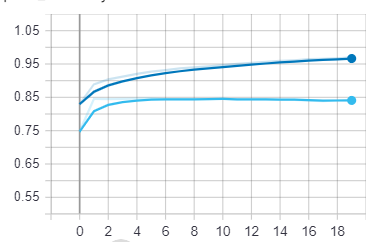

The target model gave a better result compared to this approach

### **freezing all pre-trained layers**
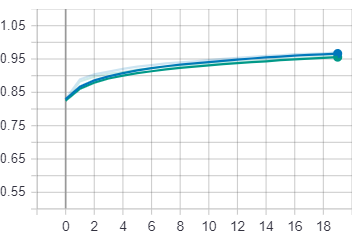

This approach gave a similar result

### **freezing only some bottom layers**

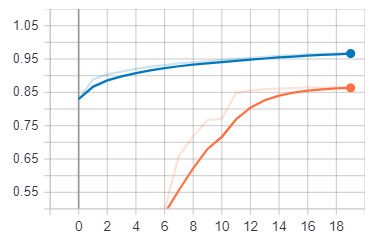

This approach gave the worst result of all other approaches.

### **replacing (or reinitializing) multiple top layers**
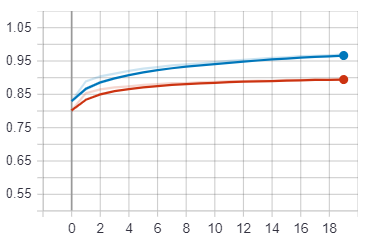

### **replacing the source classification layer by multiple new ones**
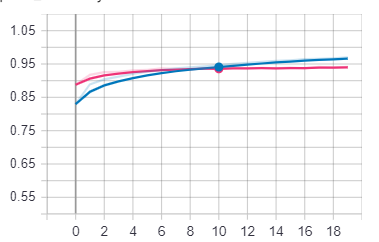

of all the other approachs this method, as expected gave the best result.